In [1]:
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
labelling_keys = {
    'Content Creation': [
        'Text generation', 'Article writing', 'Creative writing', 'Blog post generation',
        'Storytelling', 'Copywriting', 'Narrative generation', 'Automatic content creation',
        'Automated storytelling', 'Writing assistance', 'Fiction generation', 'Text synthesis',
        'Automatic summarization', 'Poetry generation', 'Script generation', 'Dialogue generation',
        'Generating ideas', 'Content automation', 'Textual creativity', 'Content personalization',
        'Content recommendation', 'Auto-response generation', 'Content enrichment', 'Sentence completion',
        'Sentence generation', 'Paragraph generation', 'Text variation', 'Text transformation',
        'Sentence restructuring', 'Text rephrasing', 'Auto-expansion of ideas', 'Text paraphrasing',
        'Text editing assistance', 'Auto-correction', 'Generating prompts', 'Automated composition',
        'Auto-generated stories', 'Content optimization', 'Language generation', 'Dialogue simulation',
        'Text augmentation', 'AI writing assistant', 'Text summarization', 'Content curation',
        'Text generation API', 'Automated storytelling', 'Dynamic content creation',
        'Content personalization', 'Automated essay writing', 'Article summarization'
    ],
    'Information Retrieval': [
        'Search engines', 'Query processing', 'Information extraction', 'Document retrieval',
        'Keyword search', 'Text indexing', 'Information access', 'Semantic search', 'Data retrieval',
        'Document clustering', 'Knowledge discovery', 'Text mining', 'Fact extraction', 'Web scraping',
        'Information filtering', 'Relevance ranking', 'Indexing algorithms', 'Data exploration',
        'Text classification', 'Document analysis', 'Information organization', 'Document ranking',
        'Data categorization', 'Text tagging', 'Entity recognition', 'Document summarization',
        'Search optimization', 'Natural language search', 'Contextual search', 'Information integration',
        'Data aggregation', 'Named entity recognition', 'Textual relevance', 'Corpus analysis',
        'Text retrieval', 'Sentiment analysis', 'Content recommendation', 'Topic modeling',
        'Information architecture', 'Information retrieval systems', 'Information extraction API',
        'Search relevance', 'Information retrieval models', 'Data mining techniques', 'Textual similarity',
        'Contextual understanding', 'Retrieval accuracy', 'Search engine optimization',
        'Content-based retrieval', 'Document similarity'
    ],
    'Natural language understanding': [
        'Sentiment analysis', 'Intent recognition', 'Language comprehension', 'Contextual understanding',
        'Text understanding', 'Language modeling', 'Semantic analysis', 'Text classification',
        'Named entity recognition', 'Entity linking', 'Text summarization', 'Information extraction',
        'Text segmentation', 'Language parsing', 'Syntax analysis', 'Discourse analysis',
        'Conversational understanding', 'Pragmatic understanding', 'Coreference resolution',
        'Semantic role labeling', 'Paraphrase detection', 'Text coherence', 'Document understanding',
        'Contextual relevance', 'Textual entailment', 'Natural language processing',
        'Question answering', 'Text annotation', 'Semantic parsing', 'Textual entailment',
        'Language understanding models', 'Semantic similarity', 'Textual entailment',
        'Contextual understanding', 'Sentence semantics', 'Textual coherence',
        'Language understanding AI', 'Textual inference', 'Language understanding algorithms',
        'Textual entailment', 'Pragmatic understanding', 'Syntactic understanding',
        'Text understanding models', 'Textual entailment', 'Natural language understanding systems',
        'Textual entailment', 'Language understanding tools'
    ],
    'Language Translation': [
        'Machine translation', 'Language conversion', 'Text translation', 'Automatic translation',
        'Multilingual translation', 'Language localization', 'Neural machine translation',
        'Bilingual translation', 'Language pair translation', 'Cross-language translation',
        'Language interpretation', 'Language synthesis', 'Speech-to-text translation',
        'Text-to-speech translation', 'Language adaptation', 'Language modeling', 'Phrase-based translation',
        'Contextual translation', 'Language mapping', 'Language understanding', 'Translation services',
        'Language conversion API', 'Language conversion tools', 'Linguistic translation',
        'Language understanding', 'Language recognition', 'Translational accuracy', 'Language proficiency',
        'Language fluency', 'Language semantics', 'Textual translation', 'Linguistic diversity',
        'Translation accuracy', 'Language understanding models', 'Translation APIs',
        'Language translation systems', 'Translation algorithms', 'Language transformation',
        'Multilingual understanding', 'Language interpretation models', 'Cross-lingual understanding',
        'Language translation technology', 'Language conversion models', 'Translation quality',
        'Language pair understanding', 'Language conversion accuracy', 'Language synthesis models',
        'Translation validation', 'Language adaptation algorithms', 'Translation error analysis'
    ]
}

In [4]:
def preprocess_text(raw_text):
    raw_text = re.sub(r'[^\w\s]', '', raw_text.lower())
    tokenized_words = raw_text.split()
    filtered_words = [word for word in tokenized_words if word not in stopwords.words('english')]
    word_lemmatizer = WordNetLemmatizer()
    lemmatized_words = [word_lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

def assign_labels(text, labelling_keys, vectorizer):
    word_lemmatizer = WordNetLemmatizer()

    # Preprocess input text
    cleaned_text = preprocess_text(text)
    text_vector = vectorizer.transform([cleaned_text])

    max_similarity = -1
    assigned_label = 'Other'

    for label, keywords in labelling_keys.items():
        # Lemmatize keywords for better matching
        keywords = [word_lemmatizer.lemmatize(word) for word in keywords]
        keyword_text = ' '.join(keywords)
        keyword_vector = vectorizer.transform([keyword_text])

        # Calculate cosine similarity between text and keywords vector
        similarity = cosine_similarity(text_vector, keyword_vector)[0][0]

        if similarity > max_similarity:
            max_similarity = similarity
            assigned_label = label

    return assigned_label


In [5]:
json_file_paths = ['discuss.json', 'issues.json', 'commit.json', 'pr_sharings.json','hn_sharings.json','file_sharing.json']
text_data = []

for path in json_file_paths:
    with open(path, 'r') as data_file:
        json_data = json.load(data_file)
        for source_item in json_data['Sources']:
            for sharing in source_item.get('ChatgptSharing', []):
                for dialogue in sharing.get('Conversations', []):
                    prompt_text = dialogue.get('Prompt', '')
                    standardized_text = preprocess_text(prompt_text)
                    text_data.append(standardized_text)
                    
def print_sample_outputs(labels, text_data, labelling_keys):
    for category, keywords in labelling_keys.items():
        print(f"Category: {category}")
        category_prompts = []
        for idx, label in enumerate(labels):
            if label == category:
                category_prompts.append(text_data[idx])

        print(f"Total Prompts: {len(category_prompts)}")
        print("-------------------------------")

        random.shuffle(category_prompts)
        sample_count = 1
        for prompt in category_prompts[:5]:  # Displaying up to 5 prompts for each category
            print(f"{sample_count}. {prompt}")
            print("-------------------------------")
            sample_count += 1

        print("\n\n")
        
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Assign labels to the data based on keywords
labels = [assign_labels(text, labelling_keys, tfidf_vectorizer) for text in text_data]
    
    
print_sample_outputs(labels, text_data, labelling_keys)

Category: Content Creation
Total Prompts: 21529
-------------------------------
1. adjust chord definition include interval step ascending order
-------------------------------
2. 10 line forest bathing earth nature immersion
-------------------------------
3. 
-------------------------------
4. thats 6
-------------------------------
5. many sunflower plant take make 1 l sunflower oil
-------------------------------



Category: Information Retrieval
Total Prompts: 2774
-------------------------------
1. great worked thanks however cant figure get back login screen iphone im using physically test app paired via xcode seems data cache kind keep login data cached know clear apps data relaunch app fresh
-------------------------------
2. uncaught referenceerror senddatatoopenai defined recordbuttononclick index3146 make transcriberjs class pas refernece function class let retryinterval 1000 start 1 second function senddatatoopenai create audio file form data send api const blob new blobc

In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data for SVM
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, encoded_labels, test_size=0.2, random_state=42)

# SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Calculate SVM accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy*100} ")

SVM Accuracy: 95.64386702330914 


In [7]:
decoded_predictions = label_encoder.inverse_transform(svm_predictions)
decoded_test_labels = label_encoder.inverse_transform(y_test)

# Generate and print SVM classification report
svm_classification_report = classification_report(decoded_test_labels, decoded_predictions)
print("SVM Classification Report:")
print(svm_classification_report)

SVM Classification Report:
                                precision    recall  f1-score   support

              Content Creation       0.96      0.99      0.98      4306
         Information Retrieval       0.93      0.83      0.88       569
          Language Translation       0.87      0.77      0.82       232
Natural language understanding       0.92      0.67      0.78       127

                      accuracy                           0.96      5234
                     macro avg       0.92      0.81      0.86      5234
                  weighted avg       0.96      0.96      0.95      5234



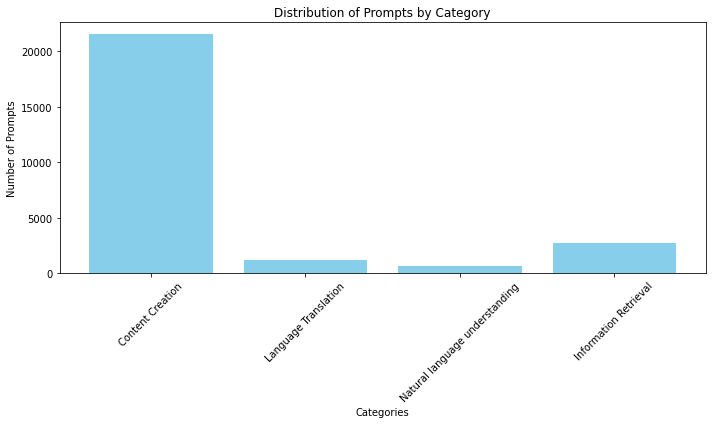

In [8]:
category_counts = {}
for label in labels:
    if label in category_counts:
        category_counts[label] += 1
    else:
        category_counts[label] = 1

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Prompts by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
new_prompt = input("Enter a prompt to classify: ")
predicted_category = assign_labels(new_prompt, labelling_keys, tfidf_vectorizer)
print(f"The predicted category for the prompt is: {predicted_category}")

Enter a prompt to classify: Generate a detailed article about the impact of artificial intelligence on healthcare
The predicted category for the prompt is: Content Creation
